In [20]:
import pandas as pd
import numpy as np
# allow multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [21]:
df = pd.read_csv("ad_clicks_100k_Treated.csv")
df.drop(columns="Unnamed: 0", inplace=True)

### Drop features that will not go into the model
- `id` (We do not need the variable ID as predictor, it does not make sense to use)
- `hour` (because hour was broken down into (day, weekday, hour_of_day)) 
- `day` (because we find that it will add no significant predictive value that makes sense in any future application, i.e. the dataset covers 10 days of the year and we have no way to know if any of those days is representative of the year, or if there was something exceptional happening. By using `hour_of_day` and `weekday` we average these values and thus make this possible effect less significant)   

## Pre-processing:
- One Hot encoding for low cardinality features 
- Label encoding for medium cardinality features
- Mean encoding for high cardinality features

In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer

In [23]:
# Split into categorical type "O" and already encoded features
categorical_columns = [i for i in list(df.columns) if df[i].dtypes in ["O"] and i not in ['id','hour','day']]
encoded_categorical_columns = [i for i in list(df.columns) if df[i].dtypes not in ["O"] and i not in ['id','hour','day']]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                100000 non-null  float64
 1   click             100000 non-null  int64  
 2   hour              100000 non-null  object 
 3   C1                100000 non-null  int64  
 4   banner_pos        100000 non-null  int64  
 5   site_id           100000 non-null  object 
 6   site_domain       100000 non-null  object 
 7   site_category     100000 non-null  object 
 8   app_id            100000 non-null  object 
 9   app_domain        100000 non-null  object 
 10  app_category      100000 non-null  object 
 11  device_id         100000 non-null  object 
 12  device_ip         100000 non-null  object 
 13  device_model      100000 non-null  object 
 14  device_type       100000 non-null  int64  
 15  device_conn_type  100000 non-null  int64  
 16  C14               100

In [25]:
data = df.copy()
one_hot = []
label_enc = []
mean_enc = []
for i in categorical_columns:
    if len(df[i].unique()) <= 15:
        # One hot encoding
        one_hot.append(i)
        data = pd.concat([data, pd.get_dummies(df[i], prefix='oneHot')],axis=1)
    elif 100 >= len(df[i].unique()) > 15:
        # Label encoding
        label_enc.append(i)
        label_encoder = []
        le = LabelEncoder()
        le.fit(data[i])    
        label_encoder.append(le)
        data[i] = le.transform(data[i])
    elif len(df[i].unique()) > 100:
        # Mean encoding
        mean_enc.append(i)
        mean_encoder = []
        le = LabelEncoder()
        le.fit(data[i])    
        mean_encoder.append(le)
        data[i] = le.transform(data[i])
        # mean_encoder_i = data.groupby([i])["click"].mean().to_dict()
        # data[i] = data[i].map(mean_encoder_i)

print('Previus Dataset Shape ->> ', df.shape)
print('Shape After Encoding  ->> ', data.shape, '\n')
print('------- Mean Encoding changes -------')
for i,v in enumerate(mean_enc):
    print(f'{v} now has {[len(data[i].unique()) for i in mean_enc][i]} categories vs {len(df[v].unique())} before')

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

Previus Dataset Shape ->>  (100000, 27)
Shape After Encoding  ->>  (100000, 34) 

------- Mean Encoding changes -------
site_id now has 1461 categories vs 1461 before
site_domain now has 1333 categories vs 1333 before
app_id now has 1296 categories vs 1296 before
device_id now has 16837 categories vs 16837 before
device_ip now has 77833 categories vs 77833 before
device_model now has 3167 categories vs 3167 before


## Split the Dataset

In [26]:
X = data.drop(columns=['click','id','hour','weekday'])
y = data['click']

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
# X_train.shape
# y_train.shape
# X_test.shape
# y_test.shape

In [27]:
#Importing required libraries
# from sklearn.datasets import load_breast_cancer
# import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn

k = 5
kf = KFold(n_splits=k, random_state=42, shuffle=True)
model = DecisionTreeClassifier(class_weight='balanced')
 
acc_acc_score = []
acc_f1_score = []
acc_roc_auc_score = []
acc_precision_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train , y_test = y[train_index], y[test_index]
    
    # Mean Encoding within CV to avoid data leakage
    for i in mean_enc:
        data_train = pd.concat([X_train, y_train], axis=1)
        mean_encoder = data_train.groupby([i])["click"].mean()
        X_train[i] = X_train[i].map(mean_encoder)
        # Transform the test set based on the train
        X_test[i] = X_test[i].map(mean_encoder)
        # Fill nan values that may arise due to mapping with the global average
        X_test[i].fillna(mean_encoder.mean(), inplace = True)
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    # Compute Scores
    acc = accuracy_score(pred_values , y_test)
    f1 = f1_score(pred_values, y_test)
    roc = roc_auc_score(pred_values, y_test)
    precision = precision_score(pred_values, y_test)

    acc_acc_score.append(acc)
    acc_f1_score.append(f1)
    acc_roc_auc_score.append(roc)
    acc_precision_score.append(precision)

avg_acc_score = sum(acc_acc_score)/k
avg_f1_score = sum(acc_f1_score)/k
avg_roc_score = sum(acc_roc_auc_score)/k
avg_precision_score = sum(acc_precision_score)/k

print('accuracy of each fold - {}'.format(acc_acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))
print('Avg f1 : {}'.format(avg_f1_score))
print('Avg roc auc : {}'.format(avg_roc_score))
print('Avg precision : {}'.format(avg_precision_score))

pd.options.mode.chained_assignment = 'warn'  # default='warn

DecisionTreeClassifier(class_weight='balanced')

DecisionTreeClassifier(class_weight='balanced')

DecisionTreeClassifier(class_weight='balanced')

DecisionTreeClassifier(class_weight='balanced')

DecisionTreeClassifier(class_weight='balanced')

accuracy of each fold - [0.73615, 0.7195, 0.74895, 0.73905, 0.75205]
Avg accuracy : 0.73914
Avg f1 : 0.21185780440718824
Avg roc auc : 0.5288823825880545
Avg precision : 0.20650320869910974


## Do more variable encoding for the remaining categories

In [28]:
for i,v in enumerate(encoded_categorical_columns):
    print(f'{v} has {[len(data[i].unique()) for i in encoded_categorical_columns][i]} unique categories')
    

click has 2 unique categories
C1 has 7 unique categories
banner_pos has 7 unique categories
device_type has 4 unique categories
device_conn_type has 4 unique categories
C14 has 1713 unique categories
C15 has 8 unique categories
C16 has 9 unique categories
C17 has 399 unique categories
C18 has 4 unique categories
C19 has 65 unique categories
C20 has 157 unique categories
C21 has 59 unique categories
hour_of_day has 24 unique categories


## Cost Sensitive Learning vs Random Under Sampling

In [38]:
from imblearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

pipe_1 = make_pipeline(StandardScaler(), DecisionTreeClassifier(class_weight='balanced'))
pipe_2 = make_pipeline(StandardScaler(), RandomUnderSampler(replacement=False), DecisionTreeClassifier())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [39]:
# Variables for average classification report
originalclass = []
predictedclass = []

#Make our customer score
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

from sklearn.model_selection import cross_validate
scores1 = cross_validate(pipe_1,
                        X_train, y_train, cv=10, return_estimator=True,
                        scoring=make_scorer(classification_report_with_accuracy_score))
                        # scoring=('roc_auc', 'recall','precision'))
print('PIPE 1')
# print(scores)
print(classification_report(originalclass, predictedclass)) 
# print('ROC AUC is', scores['test_roc_auc'].mean())
# print('Recall is ', scores['test_recall'].mean())
# print('Precision is', scores['test_precision'].mean())

scores2 = cross_validate(pipe_2,
                        X_train, y_train, cv=10, return_estimator=True,
                        scoring=make_scorer(classification_report_with_accuracy_score))
print('PIPE 2')
# print(scores)
# Average values in classification report for all folds in a K-fold Cross-validation  
print(classification_report(originalclass, predictedclass)) 

PIPE 1
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     66402
           1       0.26      0.26      0.26     13598

    accuracy                           0.75     80000
   macro avg       0.55      0.55      0.55     80000
weighted avg       0.75      0.75      0.75     80000

PIPE 2
              precision    recall  f1-score   support

           0       0.86      0.71      0.78    132804
           1       0.23      0.42      0.30     27196

    accuracy                           0.66    160000
   macro avg       0.54      0.56      0.54    160000
weighted avg       0.75      0.66      0.70    160000



In [40]:
pipe_1.fit(X_train, y_train)
pipe_2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomundersampler', RandomUnderSampler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

Text(0.5, 1.0, 'Decision Tree Balanced Weights Dataset')

Text(0.5, 1.0, 'Decision Tree Undersampling Majority Class')

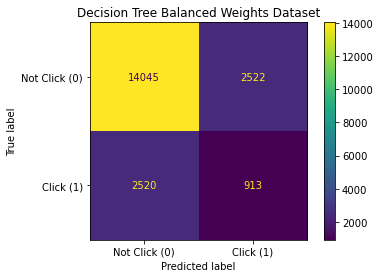

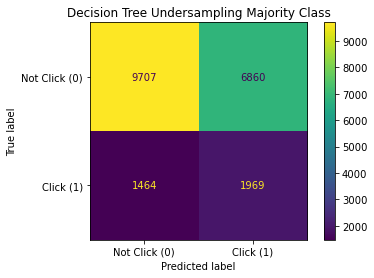

In [41]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(pipe_1, X_test, y_test, display_labels=['Not Click (0)','Click (1)'])
plt.title('Decision Tree Balanced Weights Dataset')

plot_confusion_matrix(pipe_2, X_test, y_test, display_labels=['Not Click (0)','Click (1)'])
plt.title('Decision Tree Undersampling Majority Class')

plt.show()

In [ ]:
#

asdpiosdovnfa